In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import math
import re
import os
from pykalman import KalmanFilter
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from pandas.tseries.offsets import BDay
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
sys.path.append('..')

C:\Users\applepy\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from sktime.transformations.panel.rocket import Rocket
import calendar
import workalendar
from astral.sun import sun
from astral import LocationInfo

In [3]:
import src.dax_utils as utils

In [4]:
import importlib
importlib.reload(utils)

<module 'src.dax_utils' from 'E:\\working\\pet-project\\investment-2024\\daxex\\_repo\\dax-24-strat\\proof_of_concept\\..\\src\\dax_utils.py'>

In [5]:
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('bmh')
warnings.filterwarnings("ignore")

In [6]:
try:
    df = pd.read_csv('../db/raw.csv', index_col=0, header=[0,1], parse_dates=[0])
except FileNotFoundError:
    print('Check notebook 00')

In [7]:
# df.loc["2018-04-26":, pd.IndexSlice[['Volume']]] == 0

In [8]:
# # 5, 10, or 20 - 
# Kelly criterion - MACD, Bollinger Bands, ATR - 
# Fundamental Data: Include fundamental data such as economic indicators (e.g., unemployment rates, GDP growth) - 
#     rolling correlation
# volume
# limit interactions

### Constants

In [9]:
BASE_OF_TARGET_COLUMN = 'close_gdaxi'
BASE_FEATURE_SET = ['low_bnd', 'low_gld', 'low_ief', 'low_spy', 'low_gdaxi', 'high_bnd',
       'high_gld', 'high_ief', 'high_spy', 'high_gdaxi', 'open_bnd',
       'open_gld', 'open_ief', 'open_spy', 'open_gdaxi', 'volume_bnd',
       'volume_gld', 'volume_ief', 'volume_spy', 'volume_gdaxi', 'close_bnd',
       'close_gld', 'close_ief', 'close_spy', 'close_gdaxi']
SYMBOLS = ['bnd', 'gld', 'ief', 'spy', 'gdaxi']

### Raw data cleaning

In [10]:
api_data_transformer = utils.RawDataToReturns()
df = api_data_transformer.transform(df)

### Create Target

In [11]:
target_builder = utils.BinaryTarget(forward_looking_return=5)
df = target_builder.transform(df)

In [12]:
float_cols = df.dtypes[df.dtypes == 'float64'].index

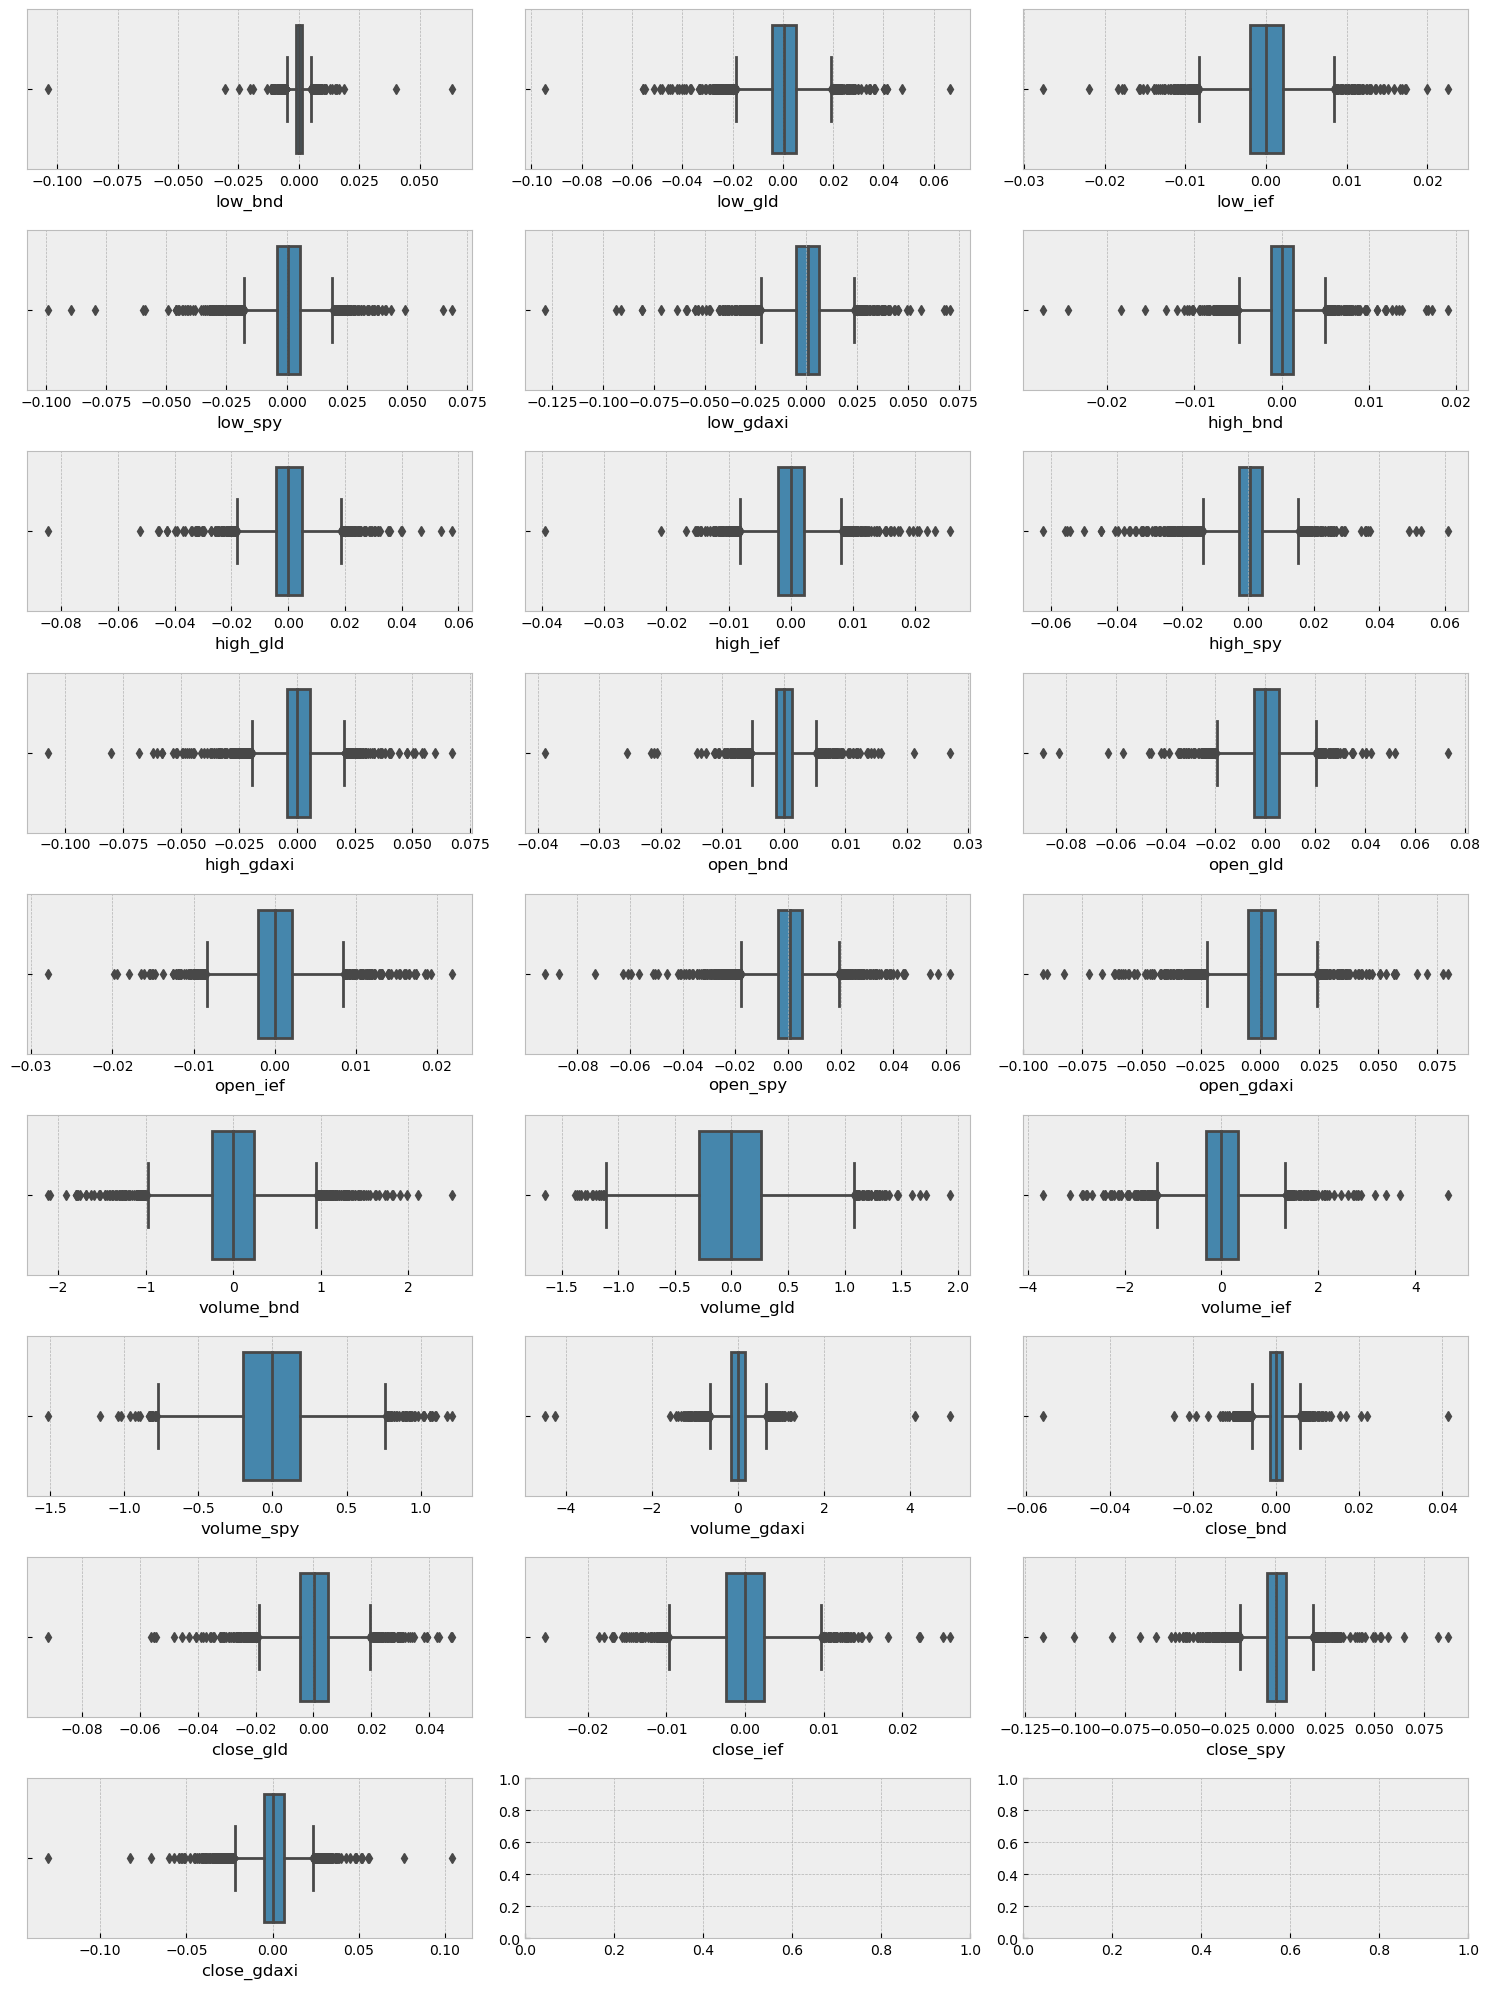

In [13]:
fig, axes = plt.subplots(nrows=math.ceil(float_cols.shape[0] / 3), ncols=3, figsize=(15, 20))
axes = axes.ravel()

for i, col in enumerate(float_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    
plt.tight_layout();

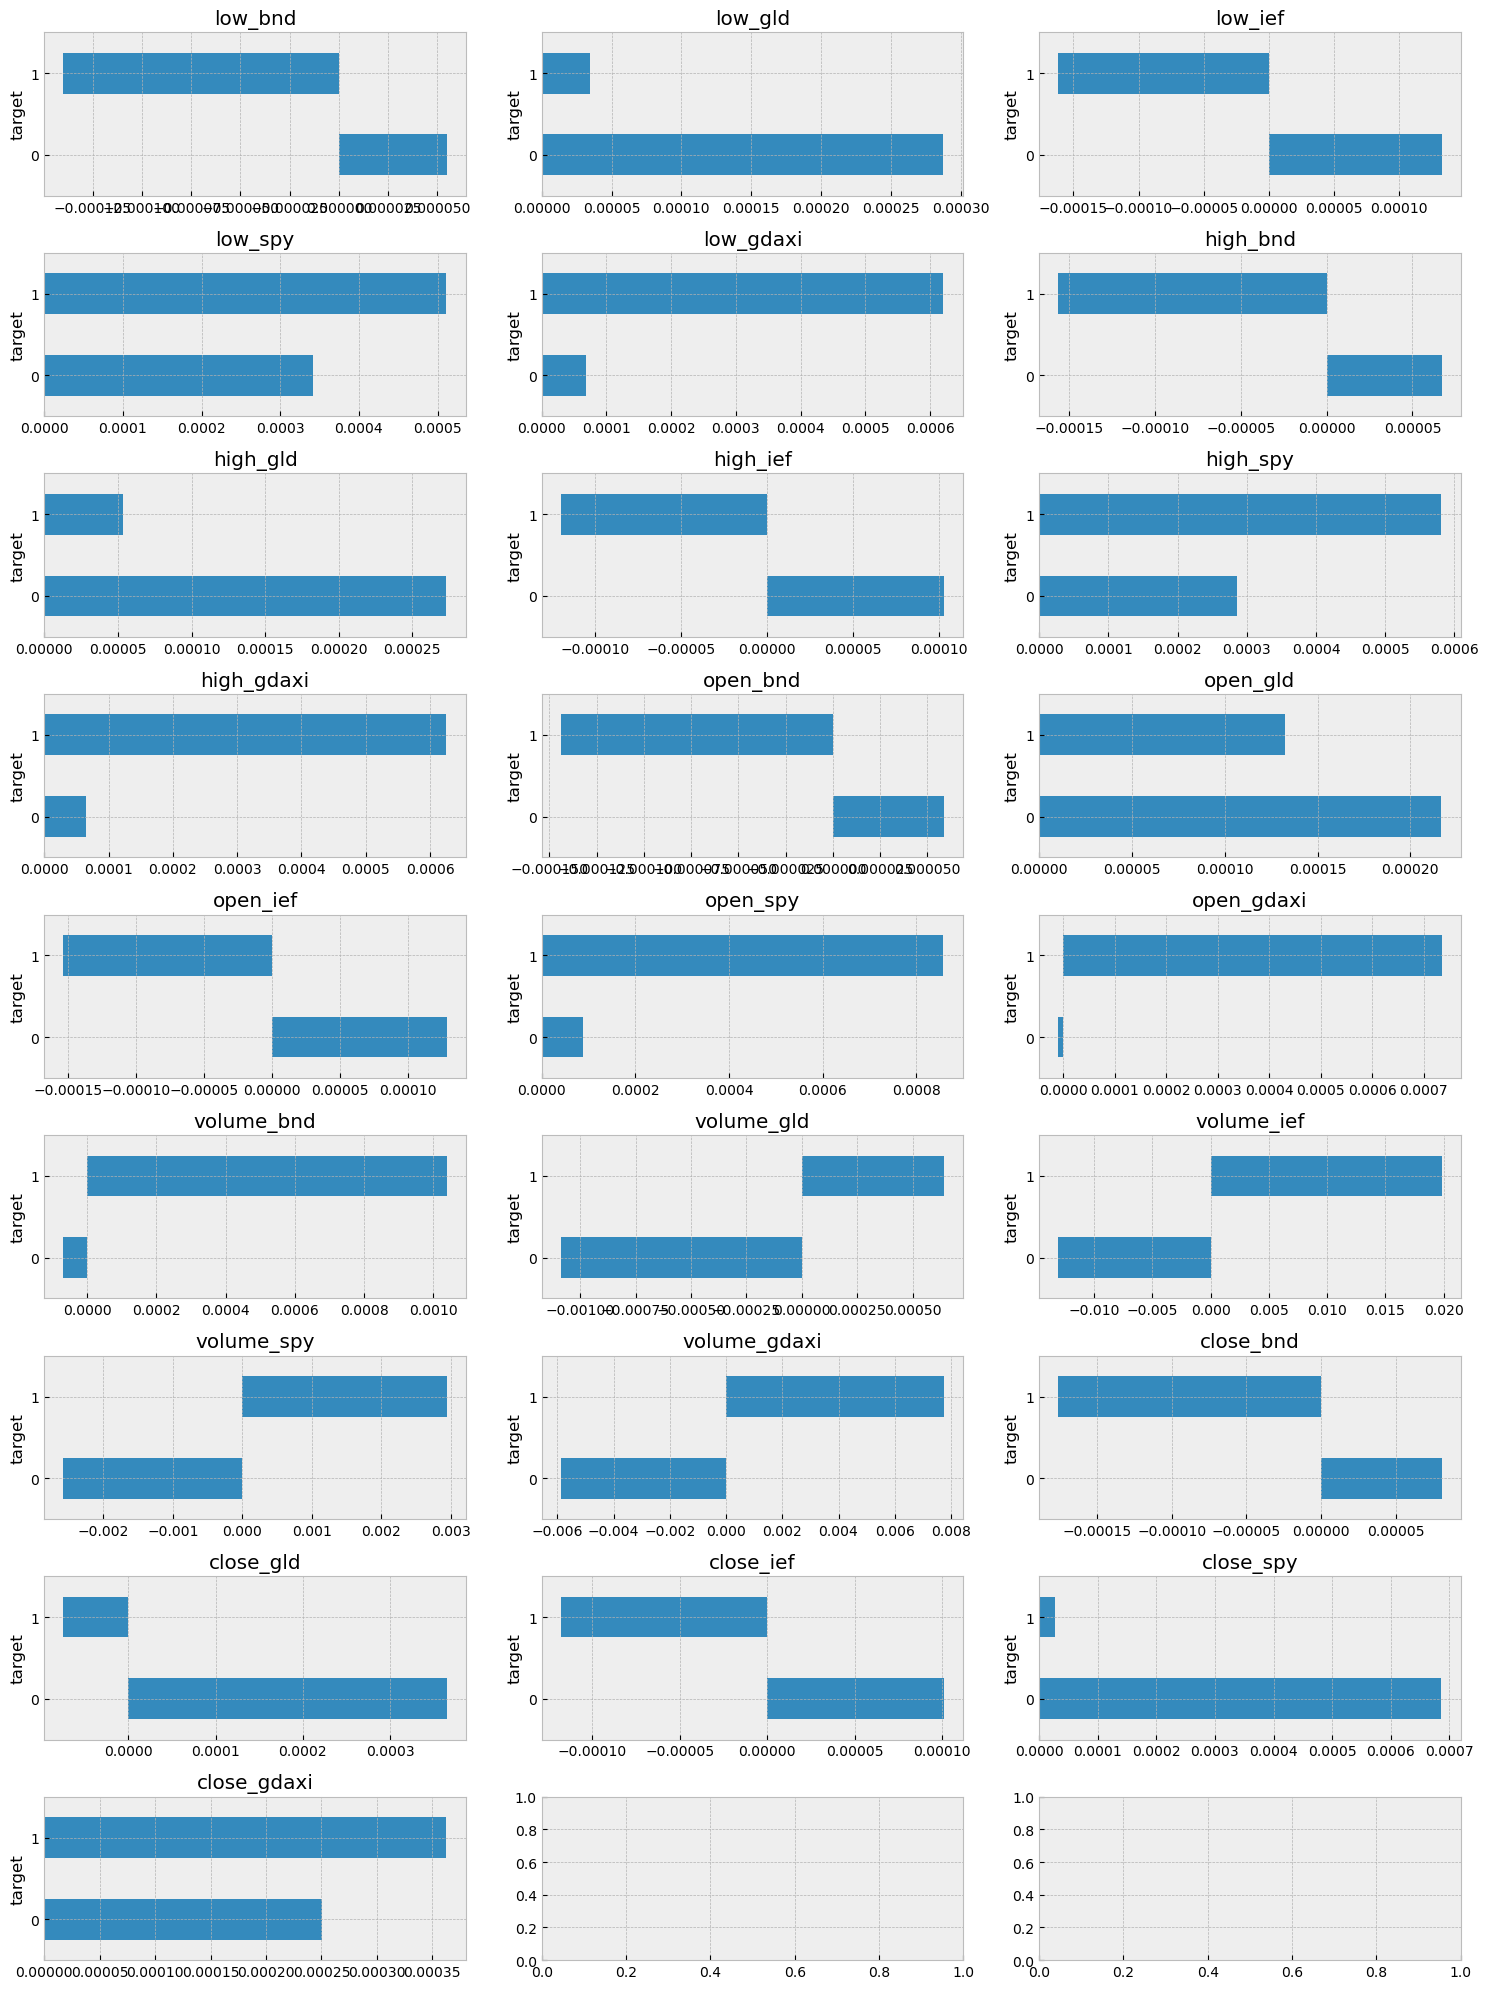

In [14]:
fig, axes = plt.subplots(nrows=math.ceil(float_cols.shape[0] / 3), ncols=3, figsize=(15, 20))
axes = axes.ravel()

for i, col in enumerate(float_cols):
    tmp = df.groupby('target')[col].agg(['mean', 'std'])
    tmp.plot(kind="barh", 
             y="mean", 
             legend=False,
             # xerr="std", 
             title=col, 
             # color='green', 
             ax=axes[i])

plt.tight_layout();

### Feature Engineering

In [15]:
day_lagger = utils.BusinessDayLaggedFeatureEngine(BASE_FEATURE_SET, days=[1, 3, 7, 20]) 
df = day_lagger.transform(df)

In [16]:
time_features = utils.TemporalFeatureEngine('index')
df = time_features.transform(df)

In [17]:
kalman = utils.KalmanMomentum([x for x in df.columns if x.endswith('gdaxi')])
df = kalman.transform(df)

In [18]:
for tck in SYMBOLS:
    rsi = utils.Relative_strength(tck)
    df = rsi.transform(df)

In [19]:
for tck in SYMBOLS:
    oscillator = utils.Stochastic_oscillator(tck)
    df = oscillator.transform(df)

In [20]:
moving_std = utils.MovingFunctionApplication([f'close_{x}' for x in SYMBOLS], 
                                             np.std, 
                                             'vol', 
                                             [3, 5])

In [21]:
high_vola = utils.MovingFunctionApplication([f'high_{x}' for x in SYMBOLS], 
                                            np.std, 
                                            'high_vol', 
                                            [3, 5])

In [22]:
low_vola = utils.MovingFunctionApplication([f'low_{x}' for x in SYMBOLS],
                                           np.std, 
                                           'low_vol', 
                                           [3, 5])

In [23]:
df = moving_std.transform(df)
df = high_vola.transform(df)
df = low_vola.transform(df)

In [24]:
moving_correlation_gld = utils.MovingFunctionApplication(
    [f'close_{x}' for x in SYMBOLS if x != 'gld'], 
    lambda x:x.corr(df['close_gld']), 
    'gld_corr', 
    [10, 30]
)


moving_correlation_spy = utils.MovingFunctionApplication(
    [f'close_{x}' for x in SYMBOLS if x != 'spy'], 
    lambda x:x.corr(df['close_spy']), 
    'spy_corr', 
    [10, 30]
)


moving_correlation_gdaxi = utils.MovingFunctionApplication(
    [f'close_{x}' for x in SYMBOLS if x != 'gdaxi'], 
    lambda x: x.corr(df['close_gdaxi']), 
    'gdaxi_corr', 
    [10, 30]
)


moving_correlation_ief = utils.MovingFunctionApplication(
    [f'close_{x}' for x in SYMBOLS if x != 'ief'], 
    lambda x: x.corr(df['close_ief']), 
    'ief_corr', 
    [10, 30]
)

moving_correlation_bnd = utils.MovingFunctionApplication(
    [f'close_{x}' for x in SYMBOLS if x != 'bnd'], 
    lambda x: x.corr(df['close_bnd']), 
    'bnd_corr', 
    [10, 30]
)

In [25]:
df = moving_correlation_gld.transform(df)
df = moving_correlation_spy.transform(df)
df = moving_correlation_gdaxi.transform(df)
df = moving_correlation_ief.transform(df)
df = moving_correlation_bnd.transform(df)

In [26]:
dispesion = utils.Dispersion([f'close_{x}' for x in SYMBOLS])
df = dispesion.transform(df)

In [27]:
sav_gol = utils.SavGolFilter([f'close_{x}' for x in SYMBOLS], winwow_sizes=[5,10], poly_orders=[2, 3])
df = sav_gol.transform(df)

### Train test split

In [28]:
# X_train, y_train = df.loc[:"2024-01-01", :].drop('target', axis=1), df.loc[:"2024-01-01", :].target
# X_test, y_test = df.loc["2024-01-01":, :].drop('target', axis=1), df.loc["2024-01-01":, :].target

In [29]:
X_train, y_train = df.loc[:"2023-01-01", :].drop('target', axis=1), df.loc[:"2023-01-01", :].target
X_test, y_test = df.loc["2023-01-01":, :].drop('target', axis=1), df.loc["2023-01-01":, :].target

In [30]:
anomaly_indicator = utils.AnomalyDetection()
anomaly_indicator.fit(X_train)

AnomalyDetection()

In [31]:
X_train = anomaly_indicator.transform(X_train)
X_test = anomaly_indicator.transform(X_test)

In [32]:
outlier_handler = utils.OutlierHandler()
outlier_handler.fit(X_train)

OutlierHandler()

In [33]:
X_train = outlier_handler.transform(X_train)
X_test = outlier_handler.transform(X_test)

### Interaction Features

In [34]:
import lightgbm as lgb

In [35]:
clf = lgb.LGBMClassifier(n_estimators=20000, random_state=42, verbosity=-1)
clf.fit(X_train, y_train)

LGBMClassifier(n_estimators=20000, random_state=42, verbosity=-1)

In [36]:
fi = pd.Series(clf.feature_importances_, clf.feature_name_).sort_values(ascending=False)

In [37]:
interaction_variables = fi.head(5).index

In [38]:
interaction_variables

Index(['close_bnd_gdaxi_corr30d', 'sunrise_dusk', 'close_bnd_gdaxi_corr10d',
       'close_ief_spy_corr30d', 'close_bnd_spy_corr30d'],
      dtype='object')

In [39]:
poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)

In [40]:
# interaction_variables = ['low_gld', 'high_bnd', 'high_gld', 'high_spy', 'volume_ief',
#        'close_bnd', 'close_gld', 'market_closed', 'low_spy_day1',
#        'low_gdaxi_day1', 'open_gdaxi_day1', 'volume_gld_day1',
#        'volume_ief_day1', 'low_spy_day3', 'high_gdaxi_day3', 'open_ief_day3',
#        'volume_bnd_day3', 'volume_gld_day3', 'volume_ief_day3',
#        'close_gdaxi_day3', 'low_bnd_day7', 'low_gld_day7', 'high_bnd_day7',
#        'high_gdaxi_day7', 'volume_bnd_day7', 'volume_ief_day7',
#        'volume_spy_day7', 'volume_gdaxi_day7', 'close_spy_day7',
#        'low_gld_day20', 'high_gld_day20', 'open_spy_day20', 'open_gdaxi_day20',
#        'volume_ief_day20', 'close_bnd_day20', 'close_gld_day20',
#        'close_spy_day20', 'close_gdaxi_day20', 'month_first_day',
#        'last_friday', 'business_days_in_month', 'open_gdaxi_kmomentum',
#        'volume_gdaxi_kmomentum', 'bnd_rsi', 'gld_rsi', 'ief_rsi', 'gdaxi_rsi',
#        'close_gdaxi_vol5d', 'high_gld_high_vol5d', 'high_spy_high_vol3d',
#        'low_bnd_low_vol5d', 'low_gld_low_vol3d', 'low_ief_low_vol5d',
#        'low_spy_low_vol3d', 'close_spy_gld_corr10d', 'close_ief_spy_corr10d',
#        'close_spy_ief_corr10d', 'savgol_close_bnd_w10_p3']

In [41]:
X_train[poly.get_feature_names_out(input_features=interaction_variables)] = poly.fit_transform(X_train[interaction_variables])
X_test[poly.get_feature_names_out(input_features=interaction_variables)] = poly.fit_transform(X_test[interaction_variables])

In [42]:
# X_train[poly.get_feature_names_out(input_features=[f'close_{x}' for x in SYMBOLS])] = poly.fit_transform(X_train[[f'close_{x}' for x in SYMBOLS]])
# X_test[poly.get_feature_names_out(input_features=[f'close_{x}' for x in SYMBOLS])] = poly.fit_transform(X_test[[f'close_{x}' for x in SYMBOLS]])

### Scaling

In [43]:
scaler = StandardScaler()

In [44]:
scaler.fit(X_train) 

StandardScaler()

In [45]:
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [46]:
X_train.shape

(3204, 264)

### Saving artifacts

In [47]:
!mkdir dataset

A subdirectory or file dataset already exists.


In [48]:
X_train.to_csv('dataset/X_train.csv')
y_train.to_csv('dataset/y_train.csv')
X_test.to_csv('dataset/X_test.csv')
y_test.to_csv('dataset/y_test.csv')